<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

<img src="https://raw.githubusercontent.com/pangeo-data/pangeo.io/refs/heads/main/public/Pangeo-assets/pangeo_logo.png"
     alt="Pangeo logo"
     style="float: center; margin-right: 10px;" />

# Aggregate Operators with Pangeo

## Aggregate Operators

### `resample`: temporal aggregation with predefined intervals

Start importing the necessary libraries.

In [29]:
# STAC Catalogue Libraries
import pystac_client
import stackstac
import rioxarray

In [30]:
spatial_extent = [11.4, 45.5, 11.42, 45.52]
temporal_extent = ["2022-01-01", "2022-12-31"]
bands = ["red","green","blue"]

In [31]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)
items = catalog.search(
    bbox=spatial_extent,
    datetime=temporal_extent,
    collections=["sentinel-2-l2a"]
).item_collection()

Create the starting Sentinel-2 datacube:

In [32]:
s2_cube = stackstac.stack(items,
                     bounds_latlon=spatial_extent,
                     assets=bands
)
s2_cube

/home/conda/cubes-and-clouds/30d8bce6e9d2d3312ad568684b7851b268e5321683bef302b527561c66bcbe23-20240905-143316-989438-487-pangeo/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-b936be125fff76f07f4c4db02d542a8f' (time: 73,
                                                                band: 3,
                                                                y: 228, x: 164)> Size: 66MB
dask.array<fetch_raster_window, shape=(73, 3, 228, 164), dtype=float64, chunksize=(1, 1, 228, 164), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 584B 2022-...
    id                                       (time) <U24 7kB 'S2B_32TPR_20220...
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 1kB 6.874e+05 ... 6....
  * y                                        (y) float64 2kB 5.044e+06 ... 5....
    s2:saturated_defective_pixel_percentage  int64 8B 0
    ...                                       ...
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(687430.0, 5041290.0, 689070.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 687430.00|\n| 0.00,-10.00, 5043570.00|\n| 0.0...
    resolution:  10.0

We might be interested in aggregating our data over periods like week, month, year etc., defining what operation to use to combine the data available in the chosen period.

Using `resample` with a sampling frequency (e.g. '1MS' ) to specify how to resample the data, we can achieve this easily:

In [33]:
s2_monthly_min = s2_cube.resample(time="1MS"). min(dim="time")

Check what happens to the datacube inspecting the resulting xArray object. Now the `time` dimension has 12 labels, one for each month.

In [34]:
s2_monthly_min

<xarray.DataArray 'stackstac-b936be125fff76f07f4c4db02d542a8f' (time: 12,
                                                                band: 3,
                                                                y: 228, x: 164)> Size: 11MB
dask.array<transpose, shape=(12, 3, 228, 164), dtype=float64, chunksize=(1, 1, 228, 164), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 1kB 6.874e+05 ... 6....
  * y                                        (y) float64 2kB 5.044e+06 ... 5....
    s2:saturated_defective_pixel_percentage  int64 8B 0
    proj:epsg                                int64 8B 32632
    mgrs:latitude_band                       <U1 4B 'T'
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32632
  * time                                     (time) datetime64[ns] 96B 2022-0...
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(687430.0, 5041290.0, 689070.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 687430.00|\n| 0.00,-10.00, 5043570.00|\n| 0.0...
    resolution:  10.0

### Spatial aggregation over an Area of Interest
One of the basic concepts in GIS is to clip data using a vector geometry. Xarray is not directly capable of dealing with vectors but thanks to Rioxarray that can be easily achieved. Rioxarray extends Xarray with most of the features that Rasterio (GDAL) brings.

Let's first define the Area of interest. It is defined in a geojson file which we can read with geopandas.

In [35]:
import geopandas as gpd

In [36]:
AOI = gpd.read_file('region.geojson')

In [37]:
AOI.geometry

0    POLYGON ((11.40818 45.51600, 11.40540 45.51819...
Name: geometry, dtype: geometry

<Axes: >

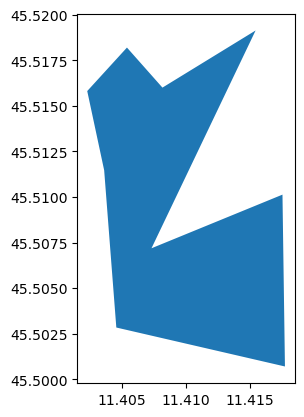

In [38]:
AOI.plot()

In a second step we set a EPSG:32632 Geodetic coordinate reference system to the polygon geometry. To achieve this we need to rely on rioxarray that extends xarray with the rasterio capabilities. The rio accessor is activated through importing rioxarray as has been done at the top.

In [40]:
s2_cube.rio.write_crs(32632, inplace=True)

<xarray.DataArray 'stackstac-b936be125fff76f07f4c4db02d542a8f' (time: 73,
                                                                band: 3,
                                                                y: 228, x: 164)> Size: 66MB
dask.array<fetch_raster_window, shape=(73, 3, 228, 164), dtype=float64, chunksize=(1, 1, 228, 164), chunktype=numpy.ndarray>
Coordinates: (12/55)
  * time                                     (time) datetime64[ns] 584B 2022-...
    id                                       (time) <U24 7kB 'S2B_32TPR_20220...
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 1kB 6.874e+05 ... 6....
  * y                                        (y) float64 2kB 5.044e+06 ... 5....
    s2:saturated_defective_pixel_percentage  int64 8B 0
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32632
    spatial_ref                              int64 8B 0
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(687430.0, 5041290.0, 689070.0...
    transform:   | 10.00, 0.00, 687430.00|\n| 0.00,-10.00, 5043570.00|\n| 0.0...
    resolution:  10.0

We reproject our AOI to the same coordinate Reference System than our sentinel-2 datacube and we clip the data with the polygon that has been obtained through geopandas at the beginning of the notebook.

In [41]:
s2_clipped = s2_cube.rio.clip(AOI.to_crs(epsg=32632).geometry, crs=32632)
s2_clipped

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

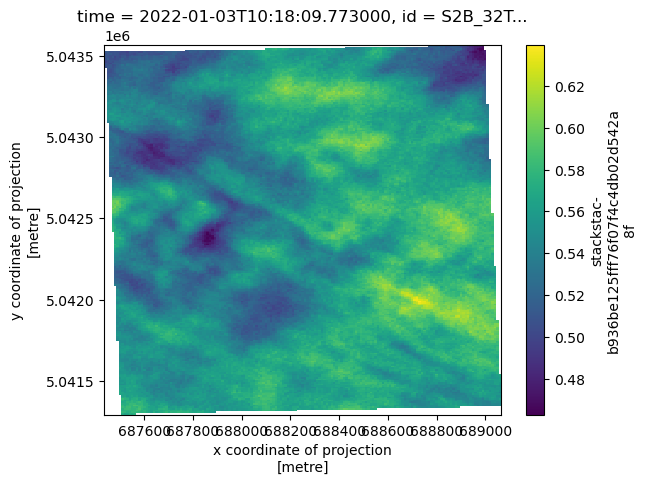

In [28]:
s2_clipped.isel(time=0).isel(band=0).plot()

## Spatial aggragation

In [46]:
region_mean_xr = s2_clipped.mean(("x", "y"))
region_mean_xr

<xarray.DataArray 'stackstac-b936be125fff76f07f4c4db02d542a8f' (time: 73,
                                                                band: 3)> Size: 2kB
dask.array<mean_agg-aggregate, shape=(73, 3), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 584B 2022-...
    id                                       (time) <U24 7kB 'S2B_32TPR_20220...
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    proj:epsg                                int64 8B 32632
    s2:medium_proba_clouds_percentage        (time) float64 584B 26.19 ... 11.74
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32632
    spatial_ref                              int64 8B 0

Finally, we can plot the resulting time series of values for a sample band:

In [49]:
region_mean_xr.sel(band="red").compute()

<xarray.DataArray 'stackstac-b936be125fff76f07f4c4db02d542a8f' (time: 73)> Size: 584B
array([ 5.52942435e-01,  5.20218009e-02,  5.84545519e-02,  6.55922827e-02,
        8.23223810e-02,  8.15154135e-02,  7.09623612e-02,  7.39643842e-02,
        7.50212492e-02,  7.08104209e-01,  7.09010752e-02,  7.08087713e-02,
       -1.25022777e-02, -1.64675603e-02, -2.26480371e-02, -7.09256561e-03,
       -1.19562000e-02,  1.41676070e-01,  5.78871500e-01, -8.37919643e-03,
        4.63446629e-02, -1.35667681e-02,  3.23293160e-01,  1.78089906e-02,
       -7.09062036e-03,  7.66510858e-01, -1.10173375e-02,  7.71550251e-01,
        6.42256292e-01,  8.24710391e-01,  9.88746622e-02, -1.40593620e-02,
       -8.20600552e-03,  4.94650704e-02,  3.79247422e-01,  1.62067765e-02,
        6.02164533e-04, -1.85209026e-03,  9.05962510e-02,  5.03614628e-04,
        7.58938247e-03,  4.14508594e-02,  4.21727382e-03,  3.79472307e-03,
       -5.73172526e-03, -1.20556766e-02,  2.75464314e-02, -1.09455189e-02,
        2.58978878e-01, -1.70702766e-02, -2.85251043e-02, -2.55117210e-02,
       -2.70512556e-02,  1.91196385e-01,  5.26915696e-01,  2.42247811e-01,
        1.52002264e-01,  3.56519375e-01,  6.81048737e-02,  8.95611091e-02,
        2.99297588e-03, -4.02052769e-02,  4.41849261e-02,  5.12994589e-01,
       -3.48589305e-02, -4.17773007e-02,  4.73404654e-01,  8.49822056e-01,
        5.02513942e-01,  3.48386362e-01,  3.99166895e-01,  2.99739747e-01,
        4.90629667e-01])
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 584B 2022-...
    id                                       (time) <U24 7kB 'S2B_32TPR_20220...
    band                                     <U5 20B 'red'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    proj:epsg                                int64 8B 32632
    s2:medium_proba_clouds_percentage        (time) float64 584B 26.19 ... 11.74
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              <U5 20B 'red'
    center_wavelength                        float64 8B 0.665
    full_width_half_max                      float64 8B 0.038
    epsg                                     int64 8B 32632
    spatial_ref                              int64 8B 0

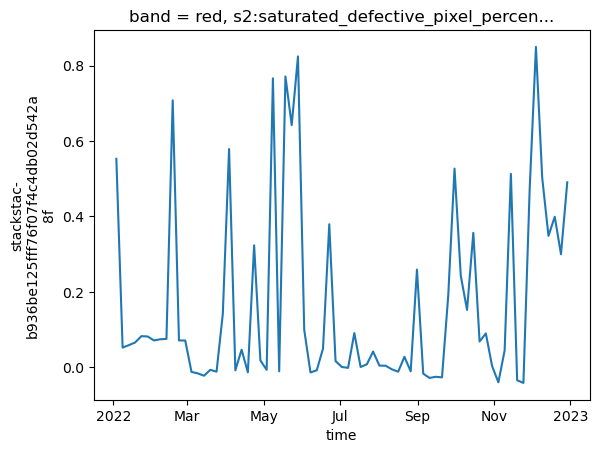

In [50]:
region_mean_xr.sel(band="red").plot()